In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train = np.load("../concated_embs_npy/X_train.npy")
y_train = np.load("../concated_embs_npy/y_train.npy")

X_test  = np.load("../concated_embs_npy/X_test.npy")
y_test  = np.load("../concated_embs_npy/y_test.npy")

X_val   = np.load("../concated_embs_npy/X_val.npy")
y_val   = np.load("../concated_embs_npy/y_val.npy")

# y_train: (N,) или (N,1)
y_train_ = y_train.ravel()

X_pos = X_train[y_train_ == 1]
X_neg = X_train[y_train_ == 0]  # если есть реальные / синтетические негативы


In [2]:
scaler = StandardScaler()
X_pos_scaled = scaler.fit_transform(X_pos)


In [3]:
pca = PCA(n_components=2, random_state=42)
X_pos_pca = pca.fit_transform(X_pos_scaled)

print("Explained variance:", pca.explained_variance_ratio_)
print("Total:", pca.explained_variance_ratio_.sum())


Explained variance: [0.26277754 0.15077579]
Total: 0.41355333213571627


In [4]:
X_neg_scaled = scaler.transform(X_neg)
X_neg_pca = pca.transform(X_neg_scaled)


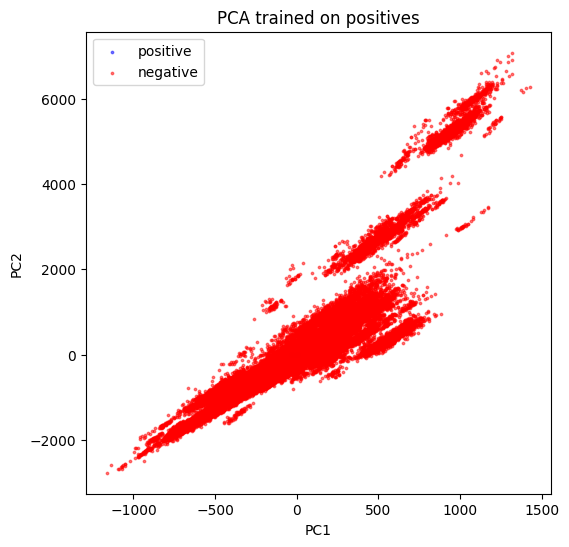

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(
    X_pos_pca[:, 0], X_pos_pca[:, 1],
    s=3, alpha=0.5, label="positive", color="blue"
)
plt.scatter(
    X_neg_pca[:, 0], X_neg_pca[:, 1],
    s=3, alpha=0.5, label="negative", color="red"
)

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA trained on positives")
plt.show()


In [12]:
# расстояние до центра позитивного облака
center = X_pos_pca.mean(axis=0)

dist_pos = np.linalg.norm(X_pos_pca - center, axis=1)
dist_neg = np.linalg.norm(X_neg_pca - center, axis=1)

print(
    dist_pos.mean(), dist_pos.std(),
    dist_neg.mean(), dist_neg.std()
)


9.20016697588666 7.59073605592547 304.8307244080896 590.794651285932


In [ ]:
#Блок проверки на дубликаты, конфликты

def row_hash_bytes(X: np.ndarray) -> np.ndarray:
    """
    Stable exact hash of each row by raw bytes (no collisions in practice for exact equality check),
    using numpy's bytes representation of each row.
    Returns array of Python bytes objects (dtype=object).
    """
    Xc = np.ascontiguousarray(X)
    # Each row as a single byte-string
    return np.fromiter((Xc[i].tobytes() for i in range(Xc.shape[0])),
                       dtype=object, count=Xc.shape[0])

def duplicates_within(X: np.ndarray):
    """
    Returns: n_duplicates_rows, n_unique_rows
    """
    h = row_hash_bytes(X)
    _, counts = np.unique(h, return_counts=True)
    n_dup = int(np.sum(counts > 1))
    n_unique = int(counts.size)
    # total duplicate rows count beyond first occurrences:
    n_dup_rows = int(np.sum(counts[counts > 1] - 1))
    return n_dup, n_dup_rows, n_unique

def overlap_between(Xa: np.ndarray, Xb: np.ndarray):
    """
    Returns number of shared unique rows between Xa and Xb.
    """
    ha = row_hash_bytes(Xa)
    hb = row_hash_bytes(Xb)
    ua = np.unique(ha)
    ub = np.unique(hb)
    inter = np.intersect1d(ua, ub, assume_unique=False)
    return int(inter.size)

def label_conflicts(X: np.ndarray, y: np.ndarray):
    """
    Detects if the same X appears with different y within the same split.
    Returns number of conflicting keys.
    """
    h = row_hash_bytes(X)
    y1 = y.ravel()
    # Map hash -> first label; check conflicts
    seen = {}
    conflicts = 0
    for key, lab in zip(h, y1):
        if key in seen and seen[key] != lab:
            conflicts += 1
        else:
            seen[key] = lab
    return conflicts

def cross_label_conflicts(Xa, ya, Xb, yb):
    """
    Same X appears in both splits but with different labels.
    Returns number of conflicting shared examples (by hash).
    """
    ha = row_hash_bytes(Xa)
    hb = row_hash_bytes(Xb)
    ya1 = ya.ravel()
    yb1 = yb.ravel()

    map_a = {}
    for k, lab in zip(ha, ya1):
        # if duplicates exist inside split with different labels, that's already bad,
        # but we keep first occurrence
        map_a.setdefault(k, lab)

    conflicts = 0
    shared = 0
    for k, lab in zip(hb, yb1):
        if k in map_a:
            shared += 1
            if map_a[k] != lab:
                conflicts += 1
    return shared, conflicts

# --------- RUN CHECKS ---------

print("Shapes:",
      "train", X_train.shape, y_train.shape,
      "val",   X_val.shape,   y_val.shape,
      "test",  X_test.shape,  y_test.shape)

# 1) Within-split duplicates
for name, X, y in [
    ("train", X_train, y_train),
    ("val",   X_val,   y_val),
    ("test",  X_test,  y_test),
]:
    n_dup_keys, n_dup_rows, n_unique = duplicates_within(X)
    conf = label_conflicts(X, y)
    print(f"\n[{name}] unique rows: {n_unique}")
    print(f"[{name}] duplicate keys (values repeated at least twice): {n_dup_keys}")
    print(f"[{name}] duplicate rows beyond first occurrences: {n_dup_rows}")
    print(f"[{name}] label conflicts within split (same X, different y): {conf}")

# 2) Cross-split overlaps
ov_tv = overlap_between(X_train, X_val)
ov_tt = overlap_between(X_train, X_test)
ov_vt = overlap_between(X_val, X_test)

print("\nCross-split overlaps (shared UNIQUE rows):")
print("train ∩ val :", ov_tv)
print("train ∩ test:", ov_tt)
print("val   ∩ test:", ov_vt)

# 3) Cross-split label conflicts
shared_tv, conf_tv = cross_label_conflicts(X_train, y_train, X_val, y_val)
shared_tt, conf_tt = cross_label_conflicts(X_train, y_train, X_test, y_test)
shared_vt, conf_vt = cross_label_conflicts(X_val, y_val, X_test, y_test)

print("\nCross-split label conflicts (same X appears in both splits):")
print(f"train–val : shared rows (counting duplicates in B): {shared_tv}, label conflicts: {conf_tv}")
print(f"train–test: shared rows (counting duplicates in B): {shared_tt}, label conflicts: {conf_tt}")
print(f"val–test  : shared rows (counting duplicates in B): {shared_vt}, label conflicts: {conf_vt}")


Shapes: train (238673, 344) (238673, 1) val (23223, 344) (23223, 1) test (41421, 344) (41421, 1)

[train] unique rows: 238534
[train] duplicate keys (values repeated at least twice): 139
[train] duplicate rows beyond first occurrences: 139
[train] label conflicts within split (same X, different y): 4

[val] unique rows: 23106
[val] duplicate keys (values repeated at least twice): 116
[val] duplicate rows beyond first occurrences: 117
[val] label conflicts within split (same X, different y): 0

[test] unique rows: 39352
[test] duplicate keys (values repeated at least twice): 1416
[test] duplicate rows beyond first occurrences: 2069
[test] label conflicts within split (same X, different y): 0

Cross-split overlaps (shared UNIQUE rows):
train ∩ val : 0
train ∩ test: 0
val   ∩ test: 0

Cross-split label conflicts (same X appears in both splits):
train–val : shared rows (counting duplicates in B): 0, label conflicts: 0
train–test: shared rows (counting duplicates in B): 0, label conflicts: 

До семплирования результат такой:
Shapes: train (238673, 344) (238673, 1) val (23223, 344) (23223, 1) test (41421, 344) (41421, 1)

[train] unique rows: 238534
[train] duplicate keys (values repeated at least twice): 139
[train] duplicate rows beyond first occurrences: 139
[train] label conflicts within split (same X, different y): 4

[val] unique rows: 23106
[val] duplicate keys (values repeated at least twice): 116
[val] duplicate rows beyond first occurrences: 117
[val] label conflicts within split (same X, different y): 0

[test] unique rows: 39352
[test] duplicate keys (values repeated at least twice): 1416
[test] duplicate rows beyond first occurrences: 2069
[test] label conflicts within split (same X, different y): 0

Cross-split overlaps (shared UNIQUE rows):
train ∩ val : 0
train ∩ test: 0
val   ∩ test: 0

Cross-split label conflicts (same X appears in both splits):
train–val : shared rows (counting duplicates in B): 0, label conflicts: 0
train–test: shared rows (counting duplicates in B): 0, label conflicts: 0
val–test  : shared rows (counting duplicates in B): 0, label conflicts: 0

После семплирования результат такой же, значит, что семплирование не добавляет новых проблем:
Shapes: train (2238673, 344) (2238673, 1) val (23223, 344) (23223, 1) test (41421, 344) (41421, 1)

[train] unique rows: 2238534
[train] duplicate keys (values repeated at least twice): 139
[train] duplicate rows beyond first occurrences: 139
[train] label conflicts within split (same X, different y): 4

[val] unique rows: 23106
[val] duplicate keys (values repeated at least twice): 116
[val] duplicate rows beyond first occurrences: 117
[val] label conflicts within split (same X, different y): 0

[test] unique rows: 39352
[test] duplicate keys (values repeated at least twice): 1416
[test] duplicate rows beyond first occurrences: 2069
[test] label conflicts within split (same X, different y): 0

Cross-split overlaps (shared UNIQUE rows):
train ∩ val : 0
train ∩ test: 0
val   ∩ test: 0

Cross-split label conflicts (same X appears in both splits):
train–val : shared rows (counting duplicates in B): 0, label conflicts: 0
train–test: shared rows (counting duplicates in B): 0, label conflicts: 0
val–test  : shared rows (counting duplicates in B): 0, label conflicts: 0